# Part C: Mixed (Invasion) Percolation

Until now we have demonstrated percolation that assumed that the important entry pressures are determined by the throat connections, i.e. ``Bond Percolation``. When modelling imbibiton the reverse can be true and in-fact the often larger pores can become the most resistive parts of the network. Occasionally processes may exist that require analysis of the phase configuration within both pores and throats and an associated entry pressure can be attributed to both elements of the network. For example, co-operative pore filling is primarily a throat driven process where a phase may be present in more than one of the connected throats for a given pore. The phases may coalesce at pressures lesser than their individual entry pressures by bulging into the pore and touching each other or other solid objects. This can be accounted for with a conditional evaluation of the the combined throat occupancy at each pore thus providing a throat and pore dependend invasion mechanism. The phenomenon is discussed in greater detail in [Tranter 2017](http://link.springer.com/10.1007/s11242-017-0973-2) and the paper recreation notebooks.

In [1]:
import warnings
import numpy as np
import openpnm as op
from openpnm.algorithms import MixedInvasionPercolation as mp
import matplotlib.pyplot as plt
np.random.seed(10)
from ipywidgets import interact, IntSlider
warnings.simplefilter("ignore")
%matplotlib inline
ws = op.Workspace()
ws.settings['loglevel'] = 50

The Mixed Invasion Percolation algorithm therefore requires a physics associated with its invading phase that contains both a pore and throat entry pressure. Initially we can set the pore entry pressure to be zero, in which case the behaviour should be identical to the normal invasion percolation algorithm.

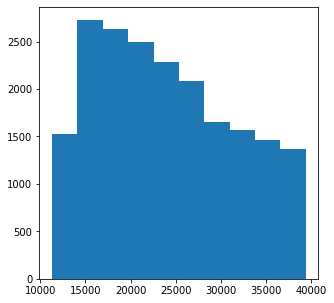

In [2]:
#NBVAL_IGNORE_OUTPUT
N = 100
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, phase=water, geometry=geom)
phys['pore.entry_pressure'] = 0.0
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(phys['throat.entry_pressure'])
plt.show()

In [3]:
def run_mp(trapping=False, residual=None, snap_off=False, plot=True, flowrate=None, phase=None):
    alg = mp(network=net)
    if snap_off:
        alg.settings['snap_off'] = 'throat.snap_off'
    alg.setup(phase=phase)
    alg.set_inlets(pores=net.pores('left'))
    if residual is not None:
        alg.set_residual(pores=residual)
    alg.run()
    if trapping:
        alg.set_outlets(net.pores('right'))
        alg.apply_trapping()
    inv_points = np.arange(0, 100, 1)
    # returns data as well as plotting
    alg_data = alg.get_intrusion_data(inv_points=inv_points)
    water.update(alg.results(Pc=inv_points.max()))
    if plot:
        fig, ax = plt.subplots(figsize=[5, 5])
        L = np.sqrt(net.Np).astype(int)
        ax.imshow(alg['pore.invasion_sequence'].reshape([L, L]),
                   cmap=plt.get_cmap('Blues'))
        plt.show()
    if flowrate is not None:
        alg.apply_flow(flowrate=flowrate)
    return alg

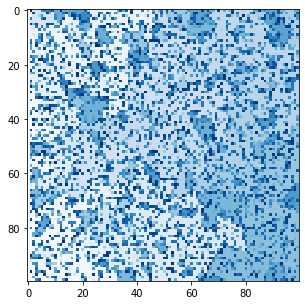

In [4]:
#NBVAL_IGNORE_OUTPUT
alg1 = run_mp(phase=water)

The intrusion data for Mixed Invasion Percolation is shown as an invasion pressure envelope, as ordinary percolation would but we can still compare the two plots.

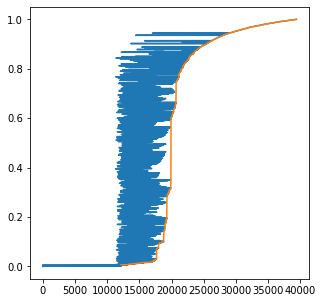

In [5]:
#NBVAL_IGNORE_OUTPUT
alg_ip = op.algorithms.InvasionPercolation(network=net)
alg_ip.setup(phase=water)
alg_ip.set_inlets(pores=net.pores('left'))
alg_ip.run()
ip_data = alg_ip.get_intrusion_data()
mip_data = alg1.get_intrusion_data()
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(ip_data.Pcap, ip_data.S_tot);
ax.plot(mip_data.Pcap, mip_data.S_tot);

Like invasion percolation, it is possible to apply trapping

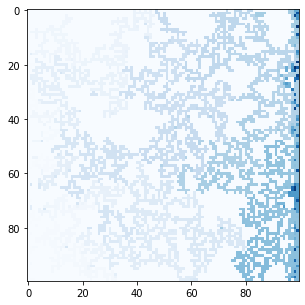

In [6]:
#NBVAL_IGNORE_OUTPUT
alg2 = run_mp(phase=water, trapping=True)

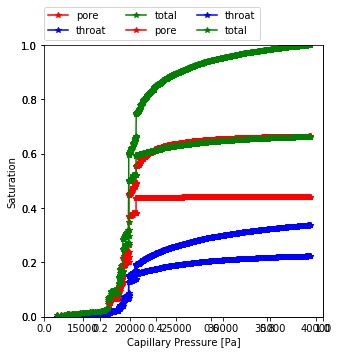

In [7]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[5, 5])
fig = alg1.plot_intrusion_curve(fig)
fig = alg2.plot_intrusion_curve(fig)

Now we show an example where a characteristic entry pressure is applied to both pores and throats

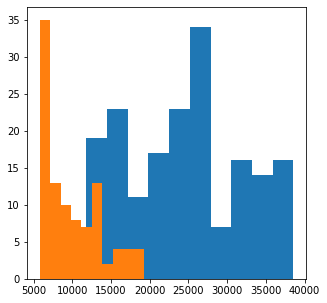

In [8]:
#NBVAL_IGNORE_OUTPUT
N = 10
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
phys = op.physics.Standard(network=net, phase=water, geometry=geom)
phys.add_model(propname='pore.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn,
               diameter='pore.diameter')
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(phys['throat.entry_pressure'])
ax.hist(phys['pore.entry_pressure'])
plt.show()

In [9]:
alg1 = run_mp(phase=water, plot=False)

We can use the basic plotting tools in OpenPNM to show that pores and throats are invaded individually by incrementing the invasion sequence

In [10]:
from openpnm.topotools import plot_coordinates, plot_connections

In [11]:
alg1.props()

['pore.cluster', 'pore.entry_pressure', 'pore.invasion_pressure', 'pore.invasion_saturation', 'pore.invasion_sequence', 'pore.trapped', 'throat.cluster', 'throat.entry_pressure', 'throat.invasion_pressure', 'throat.invasion_saturation', 'throat.invasion_sequence', 'throat.trapped']

In [12]:
def plot_invasion_sequence(seq):
    pmask = alg1['pore.invasion_sequence'] < seq
    tmask = alg1['throat.invasion_sequence'] < seq
    fig, ax = plt.subplots(figsize=[5, 5])
    fig = plot_connections(network=net, throats=net.Ts[~tmask], c='k', linestyle='dashed', fig=fig)
    fig = plot_connections(network=net, throats=net.Ts[tmask], c='b', fig=fig)
    fig = plot_coordinates(network=net, pores=net.Ps[pmask], c='b', fig=fig)
    title = 'Invaded pores: '+str(np.sum(pmask))+' Invaded throats: '+str(np.sum(tmask))
    plt.title(title)
    plt.show()

In [13]:
#NBVAL_IGNORE_OUTPUT
interact(plot_invasion_sequence, seq=IntSlider(min=1,
                                               max=alg1['throat.invasion_sequence'].max(),
                                               step=1,
                                               value=1));

interactive(children=(IntSlider(value=1, description='seq', max=270, min=1), Output()), _dom_classes=('widget-…

We can simulate drainage and imbibition using the pore entry pressure on two phases. Here we set up a new network and the appropriate phase and physics objects. We use the contact angle in the air phase as 180 - the contact angle in the water phase but these values can be changed (and often are) to represent contact angle hysteresis.

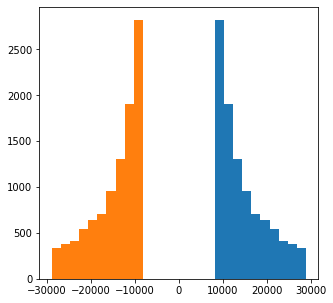

In [14]:
#NBVAL_IGNORE_OUTPUT
N = 100
net = op.network.Cubic(shape=[N, N, 1], spacing=2.5e-5)
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)
water = op.phases.Water(network=net)
air = op.phases.Air(network=net)
water['pore.contact_angle'] = 120
air['pore.contact_angle'] = 60
phys_w = op.physics.Standard(network=net, phase=water, geometry=geom)
phys_w.add_model(propname='pore.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn,
                 diameter='pore.diameter')
phys_a = op.physics.Standard(network=net, phase=air, geometry=geom)
phys_a.add_model(propname='pore.entry_pressure',
                 model=op.models.physics.capillary_pressure.washburn,
                 diameter='pore.diameter')
phys_w['throat.entry_pressure'] = -1e9
phys_a['throat.entry_pressure'] = -1e9
fig, ax = plt.subplots(figsize=[5, 5])
ax.hist(phys_w['pore.entry_pressure'])
ax.hist(phys_a['pore.entry_pressure'])
geom['pore.volume'][net['pore.surface']] = 0.0
geom['throat.volume'] = 0.0
plt.show()

Normally, an algorithm proceeds from the initial condition that the network is completley occupied with defender phase but it is also possible to start with a partially saturated network where a proportion is already invaded with ``residual`` saturation.

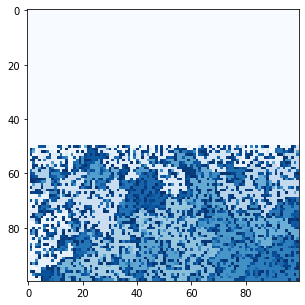

In [15]:
#NBVAL_IGNORE_OUTPUT
residual = np.zeros([N, N], dtype='bool')
residual[:50, :] = True
alg1 = run_mp(phase=water, plot=True, residual=residual.flatten())

(0, 1.0)

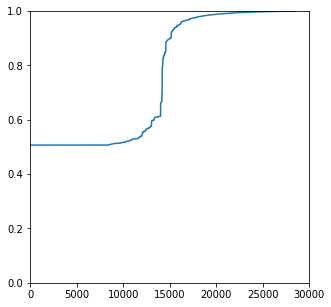

In [16]:
#NBVAL_IGNORE_OUTPUT
res_data = alg1.get_intrusion_data()
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(res_data.Pcap, res_data.S_tot)
ax.set_xlim(0, 30000)
ax.set_ylim(0, 1.0)

First we define an injection algorithm and use the ``max_pressure`` argument for the run method to stop the invasion algorithm once all the elements have been invaded with entry pressure lower than this threshold.

In [17]:
Pc_max = 14000

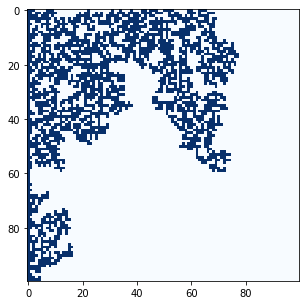

In [18]:
#NBVAL_IGNORE_OUTPUT
inj = mp(network=net)
inj.setup(phase=water)
inj.set_inlets(pores=net.pores('left'))
#inj.set_residual(pores=phase['pore.occupancy'])
inj.run(max_pressure=Pc_max)
inj.set_outlets(net.pores(['back', 'front', 'right']))
#inj.apply_trapping()
inv_points = np.arange(0, 100, 1)
# returns data as well as plotting
alg_data = inj.get_intrusion_data(inv_points=inv_points)
fig, ax = plt.subplots(figsize=[5, 5])
L = np.sqrt(net.Np).astype(int)
mask = inj['pore.invasion_sequence'] > -1
ax.imshow(mask.reshape([L, L]),
           cmap=plt.get_cmap('Blues'))
plt.show()

In [19]:
inj_data = inj.get_intrusion_data()

Now we can run the next step using the results from the injection algorithm as residual saturation. Water withdrawal is equivalent to air invasion.

In [20]:
air['pore.occupancy'] = inj['pore.invasion_sequence'] == -1
withdrawal = mp(network=net)
withdrawal.setup(phase=air)
withdrawal.set_inlets(pores=net.pores(['back', 'front', 'right']))
withdrawal.set_residual(pores=air['pore.occupancy'])
withdrawal.run()
withdrawal.set_outlets(net.pores(['right']))
# inj.apply_trapping()
# inv_points = np.arange(0, 100, 1)
# returns data as well as plotting
wth_data = withdrawal.get_intrusion_data()

Firstly we can verify that the initial condition for air invasion is the inverse of the final condition for water invasion

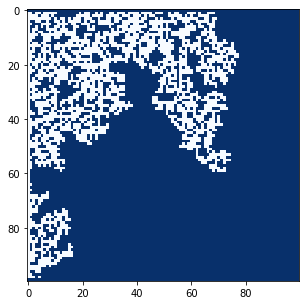

In [21]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[5, 5])
L = np.sqrt(net.Np).astype(int)
mask = withdrawal['pore.invasion_sequence'] == 0
ax.imshow(mask.reshape([L, L]),
           cmap=plt.get_cmap('Blues'));

Now we can plot both saturation curves, remembering to multiply the capillary pressure value by -1 for withdrawal at it represents pressure in the invading phases but capillary pressure is defined classically as Pc_nwp - Pc_wp. And also remembering to invert the phase occupancy for withdrawal to make it consistent with the water volume fraction

(0, 14000)

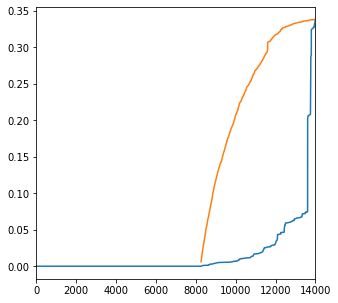

In [22]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[5, 5])
ax.plot(inj_data.Pcap, inj_data.S_tot)
ax.plot(-wth_data.Pcap, 1-wth_data.S_tot)
ax.set_xlim(0, Pc_max)